# KLI Operations: Creating and Managing Delegated AIDs 

<div class="alert alert-primary">
<b>🎯 OBJECTIVE</b><hr>
Understand the concept of delegated AIDs, where one Autonomic Identifier (AID), the delegator, grants specific authority to another AID, the delegate. This is an illustration of [cooperative delegation](https://trustoverip.github.io/tswg-keri-specification/#cooperative-delegation), meaning both parties work together to form a strongly cryptographically bound delegation relationship between the delegator and the delegate.
    
This notebook demonstrates how to create and manage delegated AIDs using the KERI Command Line Interface (KLI), covering:
<ul>
<li>The two-step cooperative process of delegated inception.</li>
<li>Performing delegated key rotation.</li>
<li>Examining the Key Event Logs (KELs) of both the delegator and the delegate to understand how the delegation is anchored and verified.</li>

## Introduction to Delegated AIDs

In KERI, delegation is a powerful mechanism that allows one AID (the delegator) to authorize another AID (the delegate) to perform certain actions such as signing. This is achieved through a cooperative cryptographic process where both parties participate in establishing the relationship. 

The primary purpose of delegation in KERI is to allow **scaling of signing authority** by setting up **delegation hierarchies**.

The delegation process is as follows:

#### Delegation Process Diagram

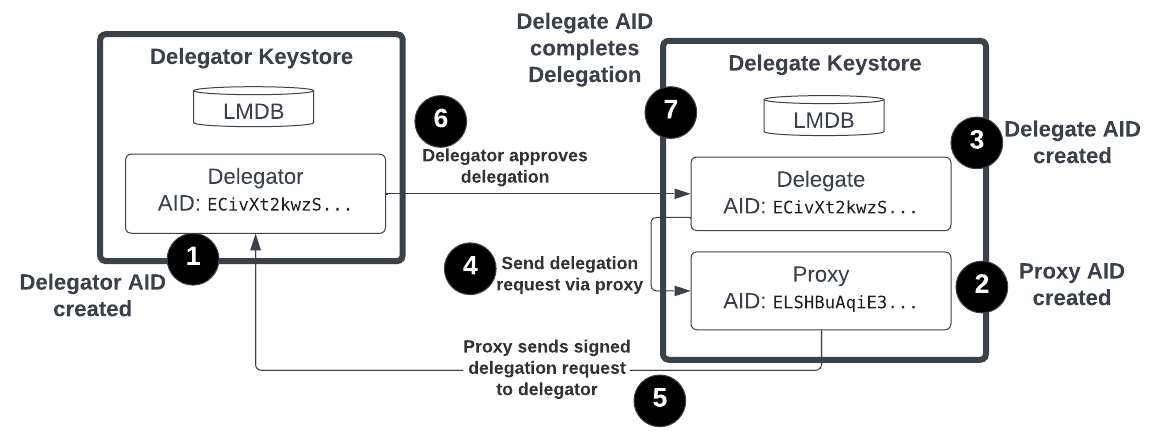

#### Process Steps

The process steps illustrated in the Delegation Process Diagram above are:
1. Create the Delegator AID. You did this earlier in the training.
2. Create the Proxy AID.
3. Create the Delegate AID and specify the Proxy AID as the communication proxy using the `--proxy` flag to `kli incept`. This process waits for completion until the Delegator AID approves the delegation. It can time out and would need to be restarted.
4. The Proxy AID signs the delegation request from the Delegate AID.
5. The Proxy AID sends the delegation request to the Delegator AID.
6. The Delegator AID receives the signed delegation request, along with the Proxy AID's KEL, verifies the signature on the delegation request, and then chooses to approve or deny the delegation.
    - In the case of an approval the Delegator AID creates an anchor (seal) and adds that anchor to it's KEL using an interaction event which signifies the Delegator's approval of the delegation. The delegator then sends its KEL containing this anchor, and witness receipts for the interaction event, to the Delegate.
7. The Delegate AID completes delegation by receiving from the Delegator AID a current copy of the delegator's KEL which now includes the anchoring delegation approval seal from the delegator combined with any witness receipts for the delegator's interaction event including this seal.

#### Result of Delegation

Once the delegation process shown above is complete you will end up with a simple delegation chain that looks like the following

```mermaid
graph BT
    %% Define event nodes
    DELEGATOR["Delegator 🔑"]
    DELEGATE["Delegate 🔑"]

    %% Define backward chaining
    DELEGATE -- delegated from -->  DELEGATOR

    %% UML appearance
    classDef eventBox fill:#f5f5f5,stroke:#000,stroke-width:1px,rx:5px,ry:5px,font-size:14px;
    class DELEGATOR,DELEGATE, eventBox;
```

#### Aspects of KERI Delegation

The strong cryptographic binding between delegator and delegate allow the delegator to fractionalize, or split up, their signing authority into multiple smaller units that allow for the straightforward scaling of signing authority. Placing an object called an "anchor" in the delegator's key event log is used to signify delegation approval. This delegation anchor is also known as a "seal." 

Major aspects of KERI delegation include:

- Cooperative Establishment: The creation (inception) and subsequent management (e.g., rotation) of a delegated AID requires coordinated, cooperative actions from both the delegate (initiating the request) and the delegator (confirming and anchoring the event). 
- Cryptographic Binding: The delegated AID's prefix is a self-addressing identifier (SAID) derived from its own delegated inception event.  This inception event, in turn, includes the delegator's AID, creating a strong cryptographic link between the delegator and the delegate.
- Anchoring: The delegator anchors the delegation to it's KEL by including a "delegated event seal" in one of its own key events.  This seal contains the delegate's AID, the sequence number of the delegated event, and a digest of that delegated event.
    - An anchor of this form is used for both delegated inception when an identifier is set up and also for delegated rotations when keys of the delegate are changed. The delegator must approve of a delegated rotation in order for a delegated identifier to rotate keys. The anchor in the KEL of the delegator functions as that approval.
- Delegated Authority: The delegator typically retains ultimate establishment control authority, while the delegate might be authorized for specific non-establishment events such as signing (interaction events) or further, limited delegations. 
- Hierarchical Structures: Delegation can be applied recursively, enabling the creation of complex hierarchical key management structures.

#### Hierarchical Delegation Diagram

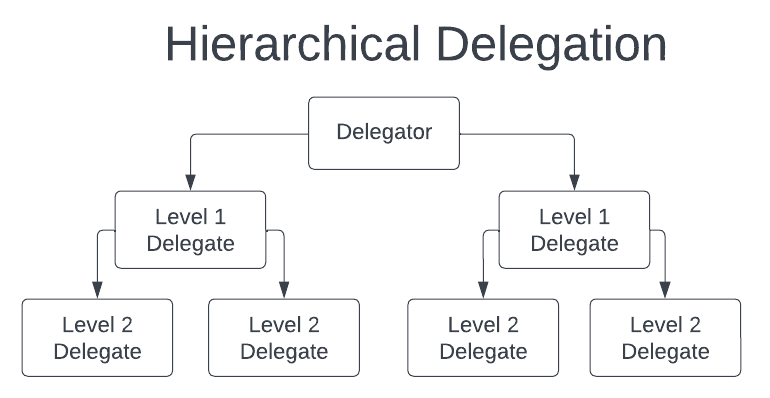

This notebook will walk through the KLI commands to perform delegated inception and delegated rotation, illustrating how these concepts are put into practice.



## Initial Setup

### Step 1: Create Keystores and Delegator AID

First, we'll set up the necessary keystores and a primary AID for the delegator. We will also initialize a keystore for the delegate. For brevity and simplicity in this notebook, passcodes for keystores are omitted using the `--nopasscode` flag. In a production deployment you would generally want to use the `--passcode <your_passcode>` argument to secure a keystore.

The `keystore_init_config.json` file is used to pre-configure the keystores with witness information.

In [ ]:
# Imports and Utility functions
from scripts.utils import exec, exec_bg, clear_keri
from scripts.utils import pr_continue, pr_title, pr_message
clear_keri()

pr_title("Initializing keystores")

# Delegate Keystore
delegate_keystore="delegate_keystore"
delegate_salt= exec("kli salt")

!kli init --name {delegate_keystore} \
    --nopasscode \
    --salt {delegate_salt} \
    --config-dir ./config \
    --config-file keystore_init_config.json

# Delegator Keystore
delegator_keystore="delegator_keystore"
delegator_salt=exec("kli salt")

!kli init --name {delegator_keystore} \
    --nopasscode \
    --salt {delegator_salt} \
    --config-dir ./config \
    --config-file keystore_init_config.json

pr_title("Incepting delegator AID")

# Delegator AID
delegator_alias = "delegator_alias"

!kli incept --name {delegator_keystore} \
    --alias {delegator_alias} \
    --icount 1 \
    --isith 1 \
    --ncount 1 \
    --nsith 1 \
    --wits BBilc4-L3tFUnfM_wJr4S4OJanAv_VmF_dJNN6vkf2Ha \
    --wits BLskRTInXnMxWaGqcpSyMgo0nYbalW99cGZESrz3zapM \
    --wits BIKKuvBwpmDVA4Ds-EpL5bt9OqPzWPja2LigFYZN2YfX \
    --toad 2 \
    --transferable

pr_title("Generating OOBIs")

# OOBI Exchange
# Delegator generates an OOBI for its AID
delegator_oobi = exec(f"kli oobi generate --name {delegator_keystore} --alias {delegator_alias} --role witness")
print("Delegator OOBI: " + delegator_oobi)

pr_title("Resolving OOBIs")
# Delegate's keystore resolves the Delegator's OOBI
!kli oobi resolve --name {delegate_keystore} \
    --oobi-alias {delegator_alias} \
    --oobi {delegator_oobi}

pr_continue()

## Creating Delegated Identifiers

Delegation is a multi-step process involving both the entity wishing to become a delegate and the entity granting the delegation (the delegator).

The above delegation process diagram is repeated for convenience.

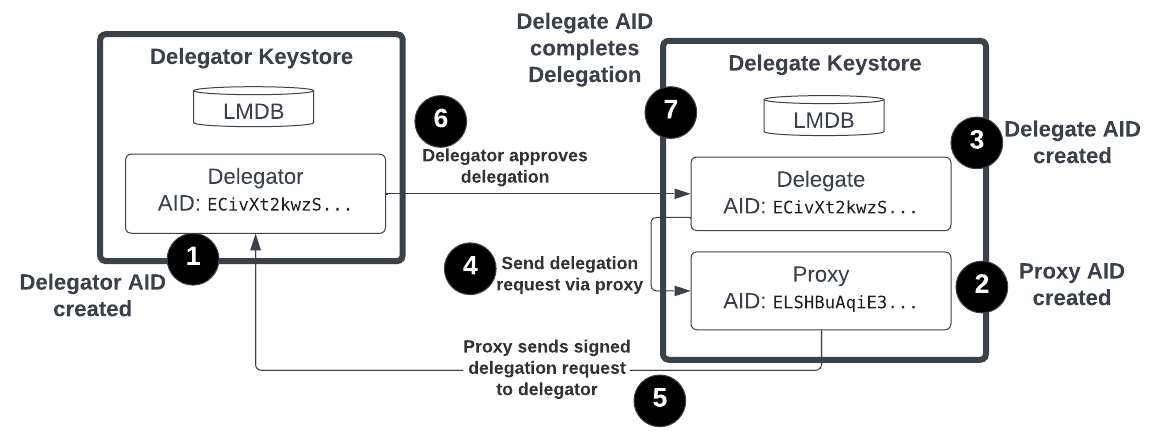

### Step 2: Delegate Incepts Proxy

The delegate needs an AID that can initiate the delegation request. This "proxy" AID is a regular AID within the delegate's keystore. It will be used to facilitate communication between the in-process delegate and the delegator until the delegator confirms the delegation and the process is complete.

In [ ]:
# Delegate proxy
pr_title("Incepting delegate proxy AID")

# This AID is in the delegate's keystore and is used to initiate the delegation request.
delegate_proxy_alias = "delegate_proxy_alias"
!kli incept --name delegate_keystore \
    --alias delegate_proxy_alias \
    --icount 1 \
    --isith 1 \
    --ncount 1 \
    --nsith 1 \
    --wits BBilc4-L3tFUnfM_wJr4S4OJanAv_VmF_dJNN6vkf2Ha \
    --wits BLskRTInXnMxWaGqcpSyMgo0nYbalW99cGZESrz3zapM \
    --wits BIKKuvBwpmDVA4Ds-EpL5bt9OqPzWPja2LigFYZN2YfX \
    --toad 2 \
    --transferable

pr_continue()

### Steps 3, 4, and 5: Delegate requests delegated AID Inception, Proxy signs and forwards  request

During the setup process the delegate uses a proxy AID to send a signed delegation request to the delegator. 

#### A Proxy is Required for Secure Communications

The use of the proxy as shown in steps 3-5 below is necessary because the delegated identifier is not fully set up and thus cannot be used to sign anything until the delegator approves the delegation. This means the delegate cannot sign its own delegation request. So, to request the inception of a new, delegated AID a separate non-delegated AID is used as a one-time, temporary communication proxy.

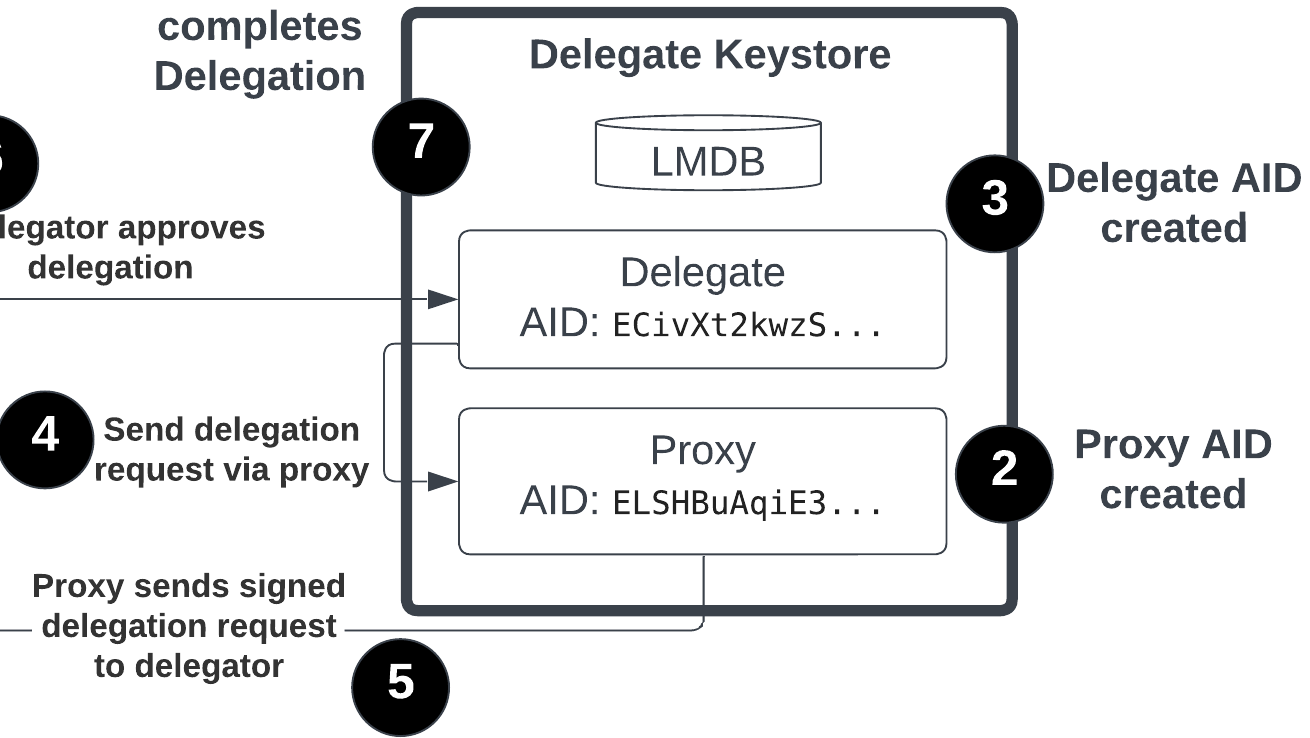

#### kli incept for the delegate 

When using `kli incept` during delegation the following arguments are needed:
- `--name` and `--alias`: Define the keystore and the alias for the new delegated AID being created.
- `--delpre`: Specifies the prefix of the AID that will be delegating authority.
- `--proxy`: Specifies the alias of the AID within the `delegate_keystore` that is making the request and will serve as the communication proxy between the delegator and the delegate (`delegate_alias`).

The `kli incept --delpre` command will initiate the process and then wait for the delegator to confirm. We run this in the background (`exec_bg`) because it will pause.

In [ ]:
pr_title("Incepting delegated AID")

delegator_pre = exec(f"kli aid --name {delegator_keystore} --alias {delegator_alias}")
pr_message("Delegator prefix: " + delegator_pre)

delegate_alias = "delegate_alias"
# Incept delegate. Note --delpre and --proxy parameters
# The command runs in the background since it waits for the delegator's confirmation
# exec_bg (execute in background) does that. Output is sent to a log file. 
# This pattern of exec_bg is repeated throughout the notebook 
command = f"""
kli incept --name {delegate_keystore} \
    --alias {delegate_alias} \
    --icount 1 \
    --isith 1 \
    --ncount 1 \
    --nsith 1 \
    --wits BBilc4-L3tFUnfM_wJr4S4OJanAv_VmF_dJNN6vkf2Ha \
    --toad 1 \
    --transferable \
    --delpre {delegator_pre} \
    --proxy {delegate_proxy_alias} > ./logs/delegate_incept.log
"""

exec_bg(command)

pr_continue()

### Step 6: Delegator confirms delegation 

The delegator now needs to confirm the delegation request. The `kli delegate confirm` command checks for pending delegation requests for the specified delegator AID and, if `--auto` is used, automatically approves them. This action creates an interaction event in the delegator's KEL that anchors the delegate's inception event as a "seal" which functions as a proof of delegation approval.

In [ ]:
# Delegator confirmation
pr_title("Confirming delegation")

command = f"""
kli delegate confirm --name {delegator_keystore} \
    --alias {delegator_alias} \
    --interact \
    --auto
"""

output = exec(command, True)

pr_message(output)

pr_continue()

Now, let's examine the status of the newly created delegated AID.

In [ ]:
pr_title(f"Delegated AID status")
!kli status --name delegate_keystore --alias delegate_alias --verbose

Key observations from the delegate's status:

- `Delegated Identifier`: This line confirms it's a delegated AID.
- `Delegator: <Some Prefix> ✔ Anchored`: This shows the delegator's prefix and confirms that the delegation has been successfully anchored in the delegator's KEL.
- In the JSON event data:
  - `"t": "dip"`: This signifies a Delegated Inception Event. This is the establishment event for the delegated AID.
  - `"di"`: This field contains the prefix of the Delegator AID. It cryptographically links this delegated AID back to its delegator.

The prefix of a delegated AID is a SAID of its own `dip` event, which includes the delegator's AID. This creates the strong cryptographic binding characteristic of KERI delegation. 

## Rotating Delegated Identifiers

Rotating the keys of a delegated AID also follows a cooperative, two-step process, similar to its inception. The delegate initiates the rotation, and the delegator must confirm it.

#### Delegated Rotation Steps:

1. Delegate performs a rotation with `kli rotate`.
2. Delegator approves the rotation with `kli delegate confirm`.

The delegate uses `kli rotate` with the`--proxy` parameter. This command is run in the background as it waits for the delegator's confirmation. The delegator confirms the delegated rotation with `kli delegate confirm`. This action creates a new anchoring event in the delegator's KEL for the delegate's rotation. The use of the `--interact` flag to `kli delegate confirm` instructs the delegator to anchor the approving seal in an interaction event.

In [ ]:
pr_title(f"Rotating delegated AID")

command = f"""
kli rotate --name {delegate_keystore} \
    --alias {delegate_alias} \
    --proxy {delegate_proxy_alias}
"""
exec_bg(command)

command = f"""
kli delegate confirm --name {delegator_keystore} \
    --alias {delegator_alias} \
    --interact \
    --auto
"""
output = exec(command, True)

# Show the output of the background processes
pr_message(f"Rotation")
pr_message(output)

pr_continue()

Now, let's examine the status of the delegate AID after the rotation.

In [ ]:
pr_title(f"Delegated AID status")
!kli status --name delegate_keystore --alias delegate_alias --verbose

Observations from the delegate's KEL after rotation:
- `Seq No: 1`: The sequence number has incremented.
- A new event has been added to the KEL with `"t": "drt"`. This signifies a Delegated Rotation Event. It's also an establishment event.
- The public keys `k` and next key digest `n` have changed, reflecting the rotation.
- The delegate's AID prefix `i` remains the same.

## Understanding the Delegator's KEL
Let's now examine the delegator's KEL to see how these delegation operations are recorded and anchored.

In [ ]:
pr_title(f"Delegator AID status")
!kli status --name delegator_keystore --alias delegator_alias --verbose

Key observations from the delegator's KEL:

- Sequence Number `s: "1"` (Interaction Event):
    - This event was created when the delegator confirmed the delegated inception.
    - The `a` (anchors/payload) array contains a delegated event seal: 
      - `"i"`: The prefix of the delegate AID.
      - `"s": "0"`: The sequence number of the delegate's event being anchored (the `dip` event at sequence 0).
      - `"d"`: The SAID (digest) of the delegate's `dip` event.
- Sequence Number `s: "2"` (Interaction Event):
  - This event was created when the delegator confirmed the delegated rotation.
  - The `a` array contains another delegated event seal:
      - `"i"`: The prefix of the delegate AID.
      - `"s": "1"`: The sequence number of the delegate's event being anchored (the drt event at sequence 1).
      - `"d"`: The SAID (digest) of the delegate's drt event.

These seals embedded within interaction events, specifically the "a" attributes section of the interaction events, in the delegator's KEL are the cryptographic proof that the delegator authorized the delegate's inception and rotation events.  Conversely, the delegated AID's `dip` event also contains a di field pointing to the delegator, and its establishment events (like `dip` and `drt`) implicitly include a delegating event location seal that refers back to the specific event in the delegator's KEL that authorized them (though not explicitly shown in the simplified `kli status` output for the delegate, this is part of the full event structure).  This creates the verifiable, cooperative link between the two AIDs.

<div class="alert alert-info">
<b>ℹ️ NOTE</b><hr>
The security of KERI's cooperative delegation model is robust. To illicitly create or rotate a delegated AID, an attacker would generally need to compromise keys from both the delegator and the delegate (specifically, the delegate's pre-rotated keys and the delegator's current signing keys for the anchoring event).  Furthermore, the delegator has mechanisms to recover a compromised delegation using something called "superseding delegated recovery rotation," covered in depth in a separate training.
</div>

<div class="alert alert-primary">
<b>📝 SUMMARY</b><hr>
KERI delegation allows an AID (delegator) to authorize another AID (delegate) for specific purposes. This is a cooperative process requiring actions from both parties.
<ul>
<li><b>Delegated Inception (<code>dip</code>):</b> The delegate initiates a request (e.g., via a proxy AID). The delegator confirms this by creating an anchoring event in its KEL, which contains a seal pointing to the delegate's <code>dip</code> event. The delegate's <code>dip</code> event includes the delegator's AID in its <code>di</code> field.  The delegate's AID prefix is a SAID of its <code>dip</code> event. </li>
<li><b>Delegated Rotation (<code>drt</code>):</b> Similar to inception, the delegate initiates the rotation, and the delegator confirms with another anchoring event in its KEL. The delegate's KEL will show a <code>drt</code> event. </li>
<li><b>Anchoring:</b> The delegator's KEL contains seals (AID, sequence number, and digest of the delegate's event) that provide verifiable proof of the authorized delegation.  This creates a strong, bi-directional cryptographic link.</li>
<li><b>Security:</b> The cooperative nature enhances security, as unauthorized delegation typically requires compromising keys from both entities. </li>
</ul>
</div>